# Asteroïde (simulations numériques en Python)

## Description

### Introduction

Avec les programmes proposés, on pourra visualiser la trajectoire de différents astéroïdes, après avoir récupéré les éphémérides sur le site du JPL. Une simulation numérique de la trajectoire est ensuite envisagée dans le référentiel ICRS, avec la présence du Soleil et des huit planètes (et la Lune).

Les étapes décrites sont suivies avec les astéroïdes mentionnés ci-dessous.

- 2024 PT5
- Apophis
- Cruithne

### Etapes suivies

On génère le fichier avec la liste des astres qui nous concerneront.
```python
planetes(Planetes='Planetes.csv',Ligne = '2024PT5,0,km^3 s^-2,2024 PT5')
```

Ce fichier a le contenu visualisé ci-dessous.
```python
        Nom            mu      units        id
0    Soleil  1.327124e+11  km^3 s^-2        10
1   Mercure  2.203187e+04  km^3 s^-2         1
2     Venus  3.248586e+05  km^3 s^-2         2
3     Terre  3.986004e+05  km^3 s^-2       399
4      Lune  4.902800e+03  km^3 s^-2       301
5      Mars  4.282838e+04  km^3 s^-2         4
6   Jupiter  1.267128e+08  km^3 s^-2         5
7   Saturne  3.794058e+07  km^3 s^-2         6
8    Uranus  5.794556e+06  km^3 s^-2         7
9   Neptune  6.836527e+06  km^3 s^-2         8
10  2024PT5  0.000000e+00  km^3 s^-2  2024 PT5
```

Les éphémérides des astres présents dans la liste sont sauvegardées dans des fichiers CSV.
```python
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2024-06-01 00:00:00',fin='2025-06-01 00:00:00',pas='24 h')
```

On peut alors visualiser la distance à laquelle l'astéroïde se trouve par rapport à un astre de référence, comme la Terre.
```python
trace2D(Astre1='Terre', Astre2='2024PT5')
```

La trajectoire de cet astéroïde peut aussi être visualisée.
```python
trace3D(Astre1='Terre', Astre2='2024PT5')
```

La simulation numérique est lancée.
```python
simu_aster_save(Planetes='Planetes.csv',methode='rk8')
```

La comparaison entre la trajectoire donnée par les éphémérides et la trajectoire simulée est alors possible.
```python
compare(Astre1_a='Terre',Astre2_a='2024PT5',Astre1_b='Terre',Astre2_b='2024PT5_simu')
```

---





## Code initial à exécuter avant d'utiliser les fonctions (fichier **asteroide.py**)

In [ ]:
# -*- coding: utf-8 -*-
"""
asteroide
@author: KM (27/09/2024)
"""
# importation des packages
import numpy as np
from numpy.linalg import norm
from datetime import datetime
from scipy.interpolate import CubicSpline
import pandas as pd
import requests as rq
import io
import matplotlib.pyplot as plt

# Génération du fichier planetes.csv


def planetes(Planetes='Planetes.csv', Ligne='2024PT5,0,km^3 s^-2,2024 PT5'):
    chaine = """
Nom,mu,units,id
Soleil,132712440041.279419,km^3 s^-2,10
Mercure,22031.868551,km^3 s^-2,1
Venus,324858.592000,km^3 s^-2,2
Terre,398600.435507,km^3 s^-2,399
Lune,4902.800118,km^3 s^-2,301
Mars,42828.375816,km^3 s^-2,4
Jupiter,126712764.100000,km^3 s^-2,5
Saturne,37940584.841800,km^3 s^-2,6
Uranus,5794556.400000,km^3 s^-2,7
Neptune,6836527.100580,km^3 s^-2,8
""" + Ligne
    f = io.StringIO(chaine)
    df_planetes = pd.read_csv(f)
    f.close()
    print(df_planetes)
    df_planetes.to_csv(Planetes, index=False)

# Lecture des fichiers CSV (liste des planètes ou éphémérides des planètes)


def lire_info_csv(nom):
    df = pd.read_csv(nom)
    return df

# requête avec l'API du JPL
# id : identifiant de l'astre
# debut,fin,pas : intervalle de temps sélectionné, et le pas temporel
# les positions et les vitesses sont données dans le référentiel ICRS
# (@SSB : Solar System Barycenter)


def req_jpl_read(id, debut='2023-01-01 00:00:00', fin='2043-01-01 00:00:00', pas='8 h'):
    # envoi de la requête (CENTER='@SSB' : Solar System Barycenter)
    rep = rq.get('https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=\''+str(id) +
                 '\'&OBJ_DATA=\'YES\'&MAKE_EPHEM=\'YES\'&EPHEM_TYPE=\'VECTORS\'&VEC_TABLE=\'2\'&CSV_FORMAT=\'YES\'&CENTER=\'@SSB\'&START_TIME=\''+debut+'\'&STOP_TIME=\''+fin+'\'&STEP_SIZE=\''+pas+'\'')
    # récupération et traitement du contenu en retour de la requête
    f = io.StringIO(rep.content.decode())
    lines = f.readlines()
    for line in lines:
        if line.find('$$SOE') != -1:
            debut = lines.index(line)
        if line.find('$$EOE') != -1:
            nlignes = lines.index(line)-debut-1
    f.close()
    # liste des lignes à ne pas prendre en compte
    skip = [n for n in range(0, debut-2)]
    skip.append(debut-1), skip.append(debut)
    # lecture du fichier de données
    f = io.StringIO(rep.content.decode())
    df = pd.read_csv(f, skiprows=skip, nrows=nlignes)
    f.close()
    # élimination de la dernière colonne qui est vide
    df = df.drop(df.columns[-1], axis=1)
    # format datetime pour les dates (en colonne 1)
    dates = pd.to_datetime(df.iloc[:, 1], format=' A.D. %Y-%b-%d %H:%M:%S.%f')
    df = df.drop(df.columns[1], axis=1)
    df.insert(1, 'DATES', dates)
    # noms des colonnes sans espace
    noms_col = [df.columns.values[n].strip()
                for n in range(len(df.columns.values))]
    df.columns = noms_col
    return df

# Les données initialement téléchargées à partir du site "JPL Horizons"
# sont reproduites dans un format plus pratique, pour d'autres utilisations


def convert_req_jpl_to_csv(Planetes='Planetes.csv', debut='2023-01-01 00:00:00', fin='2043-01-01 00:00:00', pas='8 h'):
    # Lecture des informations sur les astres
    df_planetes = pd.read_csv(Planetes)
    # Nombre d'astres considérés pour la conversion de fichier
    N = len(df_planetes)
    # sauvegarde au format csv
    for n in range(N):
        print('Données pour '+df_planetes.loc[n, 'Nom'])
        df = req_jpl_read(df_planetes.loc[n, 'id'], debut, fin, pas)
        df.to_csv(df_planetes.loc[n, 'Nom']+'.csv', index=False)


# Affichage des données du fichier contenant les éphémérides de l'astre désigné


def jpl_affiche(Astre):
    df = pd.read_csv(Astre+'.csv')
    print('**********')
    # noms des colonnes
    print('>>>noms des colonnes :'), print(df.columns.values)
    # type de chaque colonne
    print('\n>>>types des colonnes :'), print(df.dtypes)
    # contenu du dataframe
    print('\n>>>aperçu du contenu :'), print(df)
    print('**********')


# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 4)
# la fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale


def rk4(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h/2, yprec+(h/2)*k1)
        k3[:] = f(tprec+h/2, yprec+(h/2)*k2)
        k4[:] = f(tprec+h, yprec+h*k3)
        y[n, :] = yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t, y

# Méthode rk8
# (Runge-Kutta d'ordre 8)


def rk8(f, t, y0):
    y = np.zeros((len(t), len(y0)))
    k1 = np.zeros(len(y0))
    k2 = np.copy(k1)
    k3 = np.copy(k1)
    k4 = np.copy(k1)
    k5 = np.copy(k1)
    k6 = np.zeros(len(y0))
    k7 = np.copy(k1)
    k8 = np.copy(k1)
    k9 = np.copy(k1)
    k10 = np.copy(k1)
    y[0, :] = y0[:]
    for n in np.arange(1, len(t)):
        yprec = y[n-1]
        tprec = t[n-1]
        h = t[n]-tprec
        k1[:] = f(tprec, yprec)
        k2[:] = f(tprec+h*(4/27), yprec+(h*4/27)*k1)
        k3[:] = f(tprec+h*(2/9), yprec+(h/18)*(k1+3*k2))
        k4[:] = f(tprec+h*(1/3), yprec+(h/12)*(k1+3*k3))
        k5[:] = f(tprec+h*(1/2), yprec+(h/8)*(k1+3*k4))
        k6[:] = f(tprec+h*(2/3), yprec+(h/54)*(13*k1-27*k3+42*k4+8*k5))
        k7[:] = f(tprec+h*(1/6), yprec+(h/4320) *
                  (389*k1-54*k3+966*k4-824*k5+243*k6))
        k8[:] = f(tprec+h, yprec+(h/20) *
                  (-231*k1+81*k3-1164*k4+656*k5-122*k6+800*k7))
        k9[:] = f(tprec+h*(5/6), yprec+(h/288) *
                  (-127*k1+18*k3-678*k4+456*k5-9*k6+576*k7+4*k8))
        k10[:] = f(tprec+h, yprec+(h/820)*(1481*k1-81*k3 +
                   7104*k4-3376*k5+72*k6-5040*k7-60*k8+720*k9))
        y[n, :] = yprec+(h/840)*(41*k1+27*k4+272*k5+27*k6+216*k7+216*k9+41*k10)
    return t, y

# équation dynamique pour l'astéroïde


def equ_dyn_aster(t, y, mu, positions):
    N = len(mu)-1
    yp = np.zeros(6)
    yp[0:3] = y[3:6]
    P = y[0:3]
    for n in range(N):
        Pn = positions[n](t)
        yp[3:6] = yp[3:6]-mu[n] * \
            (P-Pn)/np.sqrt(sum((P-Pn)**2))**3
    return yp


# tracé en 3D d'une trajectoire relative (échelles en millions de km)


def trace3D_traj(Astre1, Astre2, XYZ, elev=30, azim=-60, roll=0):
    XYZ = XYZ/1e6
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], 'b', label=Astre2, lw=0.5)
    ax.scatter(0, 0, 0, c='r', label=Astre1)
    ax.scatter(XYZ[0, 0], XYZ[0, 1], XYZ[0, 2], c='b', label='début')
    ax.scatter(XYZ[-1, 0], XYZ[-1, 1], XYZ[-1, 2], c='g', label='fin')
    ax.set_title('Trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en millions de km)'), ax.set_ylabel(
        'Y (en millions de km)'), ax.set_zlabel('Z (en millions de km)')
    ax.axis('equal')
    ax.view_init(elev, azim, roll)
    ax.legend()

# tracé en 3D de l'erreur sur la trajectoire (JPL vs. simulation)


def trace3D_err(Astre1, Astre2, XYZ_err, elev=30, azim=-60, roll=0):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ_err[:, 0], XYZ_err[:, 1], XYZ_err[:, 2], 'b', lw=0.5)
    ax.scatter(XYZ_err[0, 0], XYZ_err[0, 1],
               XYZ_err[0, 2], c='b', label='début')
    ax.scatter(XYZ_err[-1, 0], XYZ_err[-1, 1],
               XYZ_err[-1, 2], c='g', label='fin')
    ax.set_title('Erreur sur la trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en km)'), ax.set_ylabel(
        'Y (en km)'), ax.set_zlabel('Z (en km)')
    ax.axis('equal')
    ax.view_init(elev, azim, roll)
    ax.legend()

# tracé en 2D de l'erreur sur la distance (JPL vs. simulation)


def trace2D_err(Astre1, Astre2, XYZ_err, dates):
    plt.figure(figsize=(10, 8))
    plt.plot(dates, np.sqrt(XYZ_err[:, 0]**2 +
             XYZ_err[:, 1]**2+XYZ_err[:, 2]**2), 'b', lw=0.5)
    plt.title('Erreur sur la distance '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)'), plt.ylabel('distance (en km)')
    plt.grid('on')

# tracé en 2D de la distance


def trace2D_dist(Astre1, Astre2, XYZ_dist, dates):
    plt.figure(figsize=(10, 8))
    plt.plot(dates, np.sqrt(XYZ_dist[:, 0]**2 +
             XYZ_dist[:, 1]**2+XYZ_dist[:, 2]**2)/1e6, 'b', lw=0.5)
    plt.title('Distance '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)'), plt.ylabel('distance (en millions de km)')
    plt.grid('on')

# tracé en 3D de la trajectoire selon les astres choisis


def trace3D(Astre1='Terre', Astre2='Lune', elev=30, azim=-60, roll=0):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1 = pd.read_csv(Astre1+'.csv')
    df_Astre2 = pd.read_csv(Astre2+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_jpl = df_Astre1.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_jpl = df_Astre2.loc[:, ['X', 'Y', 'Z']].to_numpy()
    XYZ_jpl = P2_jpl-P1_jpl
    # Tracé des résultats
    trace3D_traj(Astre1, Astre2, XYZ_jpl, elev, azim, roll)
    plt.show()

# tracé en 2D de la distance entre les astres choisis


def trace2D(Astre1='Terre', Astre2='Lune'):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1 = pd.read_csv(Astre1+'.csv')
    df_Astre2 = pd.read_csv(Astre2+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_jpl = df_Astre1.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_jpl = df_Astre2.loc[:, ['X', 'Y', 'Z']].to_numpy()
    XYZ_jpl = (P2_jpl-P1_jpl)
    # Tracé des résultats
    trace2D_dist(Astre1, Astre2, XYZ_jpl,
                 pd.to_datetime(df_Astre1.loc[:, 'DATES']))
    plt.show()

# comparaison de trajectoires (a : référence, b : calcul)


def compare(Astre1_a='Terre', Astre2_a='Lune', Astre1_b='Terre_simu', Astre2_b='Lune_simu', elev=30, azim=-60, roll=0):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1_a = pd.read_csv(Astre1_a+'.csv')
    df_Astre2_a = pd.read_csv(Astre2_a+'.csv')
    df_Astre1_b = pd.read_csv(Astre1_b+'.csv')
    df_Astre2_b = pd.read_csv(Astre2_b+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_a = df_Astre1_a.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_a = df_Astre2_a.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P1_b = df_Astre1_b.loc[:, ['X', 'Y', 'Z']].to_numpy()
    P2_b = df_Astre2_b.loc[:, ['X', 'Y', 'Z']].to_numpy()
    # calcul de la position relative
    XYZ_a = P2_a-P1_a
    XYZ_b = P2_b-P1_b
    # Erreur entre valeurs des éphémérides
    XYZ_err = XYZ_b-XYZ_a
    # Tracé des résultats
    trace3D_traj(Astre1_b, Astre2_b, XYZ_b, elev, azim, roll)
    trace3D_err(Astre1_b, Astre2_b, XYZ_err, elev, azim, roll)
    trace2D_err(Astre1_b, Astre2_b, XYZ_err,
                pd.to_datetime(df_Astre1_b.loc[:, 'DATES']))
    trace2D_dist(Astre1_b, Astre2_b, XYZ_b,
                 pd.to_datetime(df_Astre1_b.loc[:, 'DATES']))
    plt.show()

# simulation numérique de la trajectoire de l'asteroïde


def simu_aster_save(Planetes='Planetes.csv', methode='rk8'):
    # choix de la méthode d'intégration numérique
    if methode == 'rk4':
        meth = rk4
    if methode == 'rk8':
        meth = rk8
    # Lecture des informations sur les astres
    df_planetes = lire_info_csv(Planetes)
    # Nombre d'astres considérés pour la simulation
    N = len(df_planetes)
    # Liste des paramètres gravitationnels standards
    mu = []
    for n in range(N):
        print(df_planetes.loc[n, 'Nom']+' : ' +
              str(df_planetes.loc[n, 'mu'])+' '+df_planetes.loc[n, 'units'])
        mu.append(df_planetes.loc[n, 'mu'])
    # Lectures des valeurs initiales dans les fichiers d'éphémérides
    vi = pd.read_csv(df_planetes.loc[N-1, 'Nom']+'.csv', nrows=1)
    # Constitution de la condition initiale
    y0 = []
    y0 = np.concatenate((y0, vi.loc[0, ['X', 'Y', 'Z']].values))
    y0 = np.concatenate((y0, vi.loc[0, ['VX', 'VY', 'VZ']].values))
    y0 = y0.flatten()
    df_temps = pd.read_csv('Soleil.csv')
    t_jpl = 3600*24*(df_temps.loc[:, 'JDTDB']-df_temps.loc[0, 'JDTDB']).values
    positions = []
    for n in range(N-1):
        df_Astre = pd.read_csv(df_planetes.loc[n, 'Nom']+'.csv')
        XYZ = df_Astre.loc[:, ['X', 'Y', 'Z']].values
        positions.append(CubicSpline(t_jpl, XYZ))
    # Lancement de la simulation numérique
    print('début de la simulation numérique')
    start = datetime.now()
    _, y = meth(lambda t, y: equ_dyn_aster(t, y, mu, positions), t_jpl, y0)
    end = datetime.now()
    print(f'fin de la simulation à {end - start} (hh:mm:ss.ms)')
    df_Astre = pd.read_csv(df_planetes.loc[N-1, 'Nom']+'.csv')
    df_Astre_simu = df_Astre.copy()
    df_Astre_simu = df_Astre_simu.drop(df_Astre_simu.columns[2:], axis=1)
    df_Astre_simu.insert(2, 'X', y[:, 0])
    df_Astre_simu.insert(3, 'Y', y[:, 1])
    df_Astre_simu.insert(4, 'Z', y[:, 2])
    df_Astre_simu.insert(5, 'VX', y[:, 3])
    df_Astre_simu.insert(6, 'VY', y[:, 4])
    df_Astre_simu.insert(7, 'VZ', y[:, 5])
    df_Astre_simu.to_csv(
        df_planetes.loc[N-1, 'Nom']+'_simu.csv', index=False)


## 2024 PT5

In [ ]:
planetes(Planetes='Planetes.csv',Ligne = '2024PT5,0,km^3 s^-2,2024 PT5')

        Nom            mu      units        id
0    Soleil  1.327124e+11  km^3 s^-2        10
1   Mercure  2.203187e+04  km^3 s^-2         1
2     Venus  3.248586e+05  km^3 s^-2         2
3     Terre  3.986004e+05  km^3 s^-2       399
4      Lune  4.902800e+03  km^3 s^-2       301
5      Mars  4.282838e+04  km^3 s^-2         4
6   Jupiter  1.267128e+08  km^3 s^-2         5
7   Saturne  3.794058e+07  km^3 s^-2         6
8    Uranus  5.794556e+06  km^3 s^-2         7
9   Neptune  6.836527e+06  km^3 s^-2         8
10  2024PT5  0.000000e+00  km^3 s^-2  2024 PT5


In [ ]:
df=lire_info_csv('Planetes.csv')
print(df)

        Nom            mu      units        id
0    Soleil  1.327124e+11  km^3 s^-2        10
1   Mercure  2.203187e+04  km^3 s^-2         1
2     Venus  3.248586e+05  km^3 s^-2         2
3     Terre  3.986004e+05  km^3 s^-2       399
4      Lune  4.902800e+03  km^3 s^-2       301
5      Mars  4.282838e+04  km^3 s^-2         4
6   Jupiter  1.267128e+08  km^3 s^-2         5
7   Saturne  3.794058e+07  km^3 s^-2         6
8    Uranus  5.794556e+06  km^3 s^-2         7
9   Neptune  6.836527e+06  km^3 s^-2         8
10  2024PT5  0.000000e+00  km^3 s^-2  2024 PT5


In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2024-06-01 00:00:00',fin='2025-06-01 00:00:00',pas='24 h')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour 2024PT5


In [ ]:
jpl_affiche('2024PT5')

**********
>>>noms des colonnes :
['JDTDB' 'DATES' 'X' 'Y' 'Z' 'VX' 'VY' 'VZ']

>>>types des colonnes :
JDTDB    float64
DATES     object
X        float64
Y        float64
Z        float64
VX       float64
VY       float64
VZ       float64
dtype: object

>>>aperçu du contenu :
         JDTDB       DATES             X             Y             Z  \
0    2460462.5  2024-06-01 -5.146588e+07 -1.387734e+08 -2.431626e+06   
1    2460463.5  2024-06-02 -4.907339e+07 -1.397387e+08 -2.432933e+06   
2    2460464.5  2024-06-03 -4.666598e+07 -1.406609e+08 -2.433429e+06   
3    2460465.5  2024-06-04 -4.424445e+07 -1.415397e+08 -2.433112e+06   
4    2460466.5  2024-06-05 -4.180956e+07 -1.423751e+08 -2.431981e+06   
..         ...         ...           ...           ...           ...   
361  2460823.5  2025-05-28 -6.735826e+07 -1.391965e+08 -3.198783e+06   
362  2460824.5  2025-05-29 -6.508792e+07 -1.403105e+08 -3.145567e+06   
363  2460825.5  2025-05-30 -6.279995e+07 -1.413864e+08 -3.091460e+06   
36

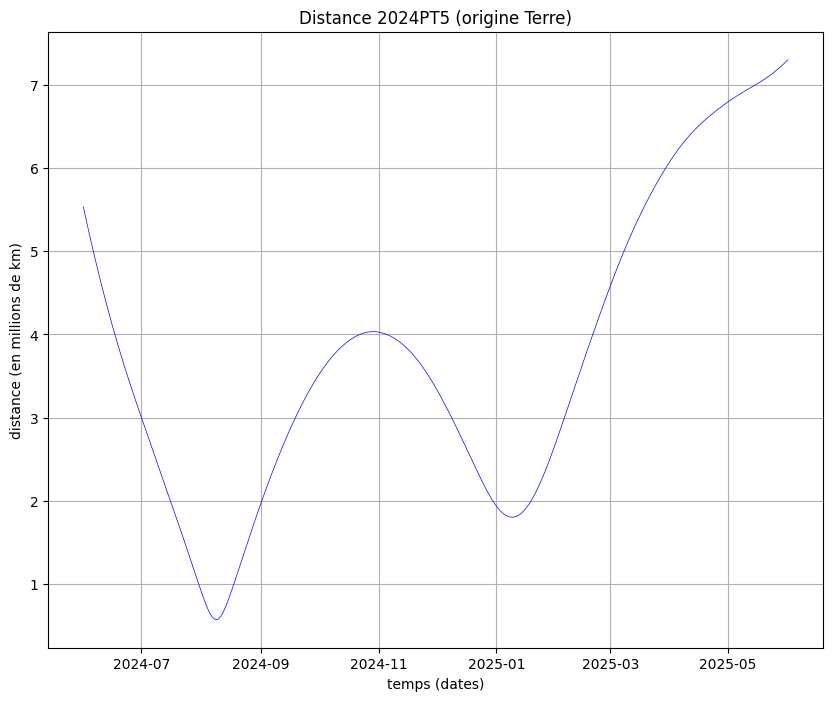

In [ ]:
trace2D(Astre1='Terre', Astre2='2024PT5')

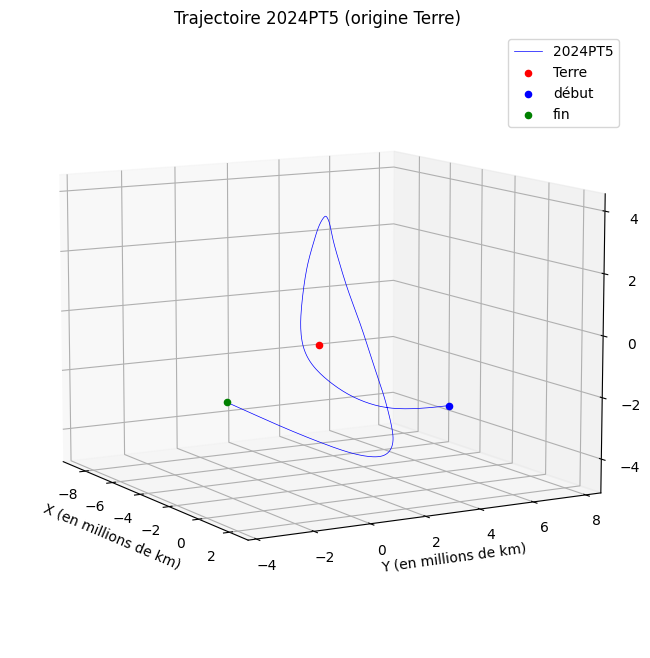

In [ ]:
trace3D(Astre1='Terre', Astre2='2024PT5', elev = 10, azim = -30)

In [ ]:
simu_aster_save(Planetes='Planetes.csv',methode='rk8')

Soleil : 132712440041.2794 km^3 s^-2
Mercure : 22031.868551 km^3 s^-2
Venus : 324858.592 km^3 s^-2
Terre : 398600.435507 km^3 s^-2
Lune : 4902.800118 km^3 s^-2
Mars : 42828.375816 km^3 s^-2
Jupiter : 126712764.1 km^3 s^-2
Saturne : 37940584.8418 km^3 s^-2
Uranus : 5794556.4 km^3 s^-2
Neptune : 6836527.10058 km^3 s^-2
2024PT5 : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:01.526056 (hh:mm:ss.ms)


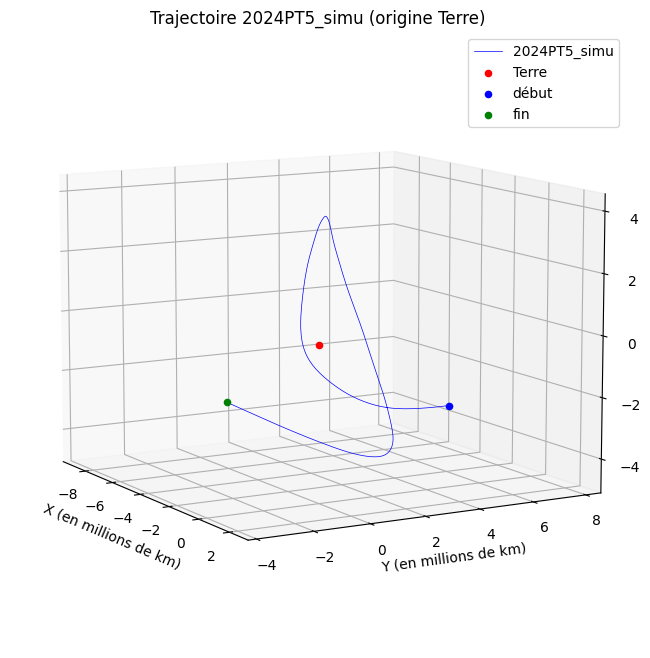

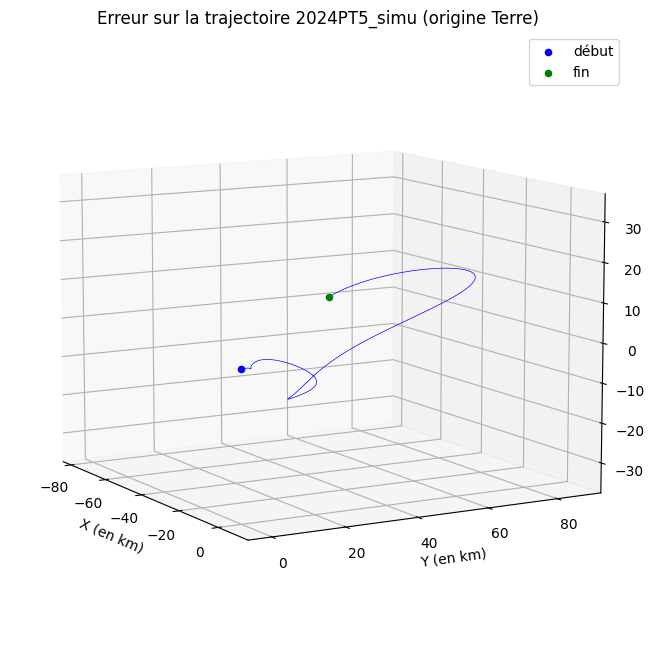

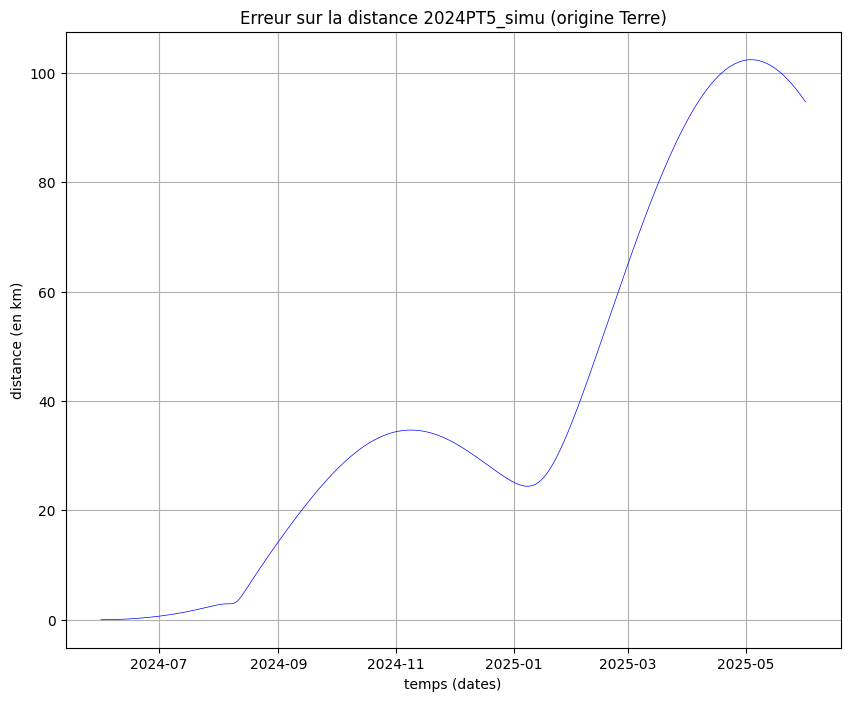

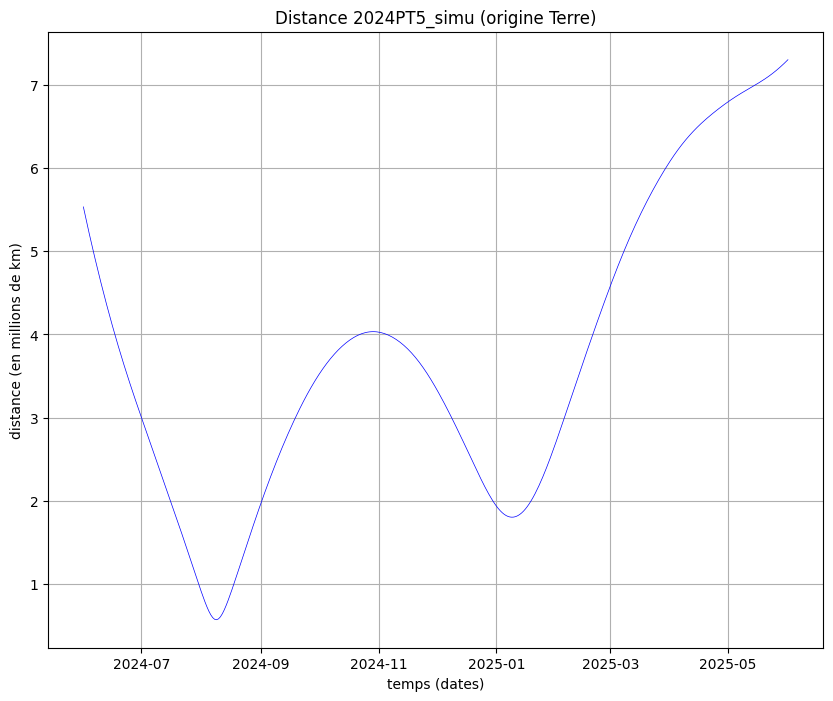

In [ ]:
compare(Astre1_a='Terre',Astre2_a='2024PT5',Astre1_b='Terre',Astre2_b='2024PT5_simu', elev = 10, azim = -30)

## Apophis

In [ ]:
planetes(Planetes='Planetes.csv',Ligne = 'Apophis,0,km^3 s^-2,Apophis')

        Nom            mu      units       id
0    Soleil  1.327124e+11  km^3 s^-2       10
1   Mercure  2.203187e+04  km^3 s^-2        1
2     Venus  3.248586e+05  km^3 s^-2        2
3     Terre  3.986004e+05  km^3 s^-2      399
4      Lune  4.902800e+03  km^3 s^-2      301
5      Mars  4.282838e+04  km^3 s^-2        4
6   Jupiter  1.267128e+08  km^3 s^-2        5
7   Saturne  3.794058e+07  km^3 s^-2        6
8    Uranus  5.794556e+06  km^3 s^-2        7
9   Neptune  6.836527e+06  km^3 s^-2        8
10  Apophis  0.000000e+00  km^3 s^-2  Apophis


In [ ]:
df=lire_info_csv('Planetes.csv')
print(df)

        Nom            mu      units       id
0    Soleil  1.327124e+11  km^3 s^-2       10
1   Mercure  2.203187e+04  km^3 s^-2        1
2     Venus  3.248586e+05  km^3 s^-2        2
3     Terre  3.986004e+05  km^3 s^-2      399
4      Lune  4.902800e+03  km^3 s^-2      301
5      Mars  4.282838e+04  km^3 s^-2        4
6   Jupiter  1.267128e+08  km^3 s^-2        5
7   Saturne  3.794058e+07  km^3 s^-2        6
8    Uranus  5.794556e+06  km^3 s^-2        7
9   Neptune  6.836527e+06  km^3 s^-2        8
10  Apophis  0.000000e+00  km^3 s^-2  Apophis


In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2029-04-01 00:00:00',fin='2029-04-30 00:00:00',pas='1 h')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour Apophis


In [ ]:
jpl_affiche('Apophis')


**********
>>>noms des colonnes :
['JDTDB' 'DATES' 'X' 'Y' 'Z' 'VX' 'VY' 'VZ']

>>>types des colonnes :
JDTDB    float64
DATES     object
X        float64
Y        float64
Z        float64
VX       float64
VY       float64
VZ       float64
dtype: object

>>>aperçu du contenu :
            JDTDB                DATES             X             Y  \
0    2.462228e+06  2029-04-01 00:00:00 -1.512950e+08 -3.322872e+07   
1    2.462228e+06  2029-04-01 01:00:00 -1.512600e+08 -3.332071e+07   
2    2.462228e+06  2029-04-01 02:00:00 -1.512251e+08 -3.341268e+07   
3    2.462228e+06  2029-04-01 03:00:00 -1.511900e+08 -3.350463e+07   
4    2.462228e+06  2029-04-01 04:00:00 -1.511549e+08 -3.359657e+07   
..            ...                  ...           ...           ...   
692  2.462256e+06  2029-04-29 20:00:00 -1.085019e+08 -9.353796e+07   
693  2.462256e+06  2029-04-29 21:00:00 -1.084145e+08 -9.361493e+07   
694  2.462256e+06  2029-04-29 22:00:00 -1.083270e+08 -9.369185e+07   
695  2.462256e+06  202

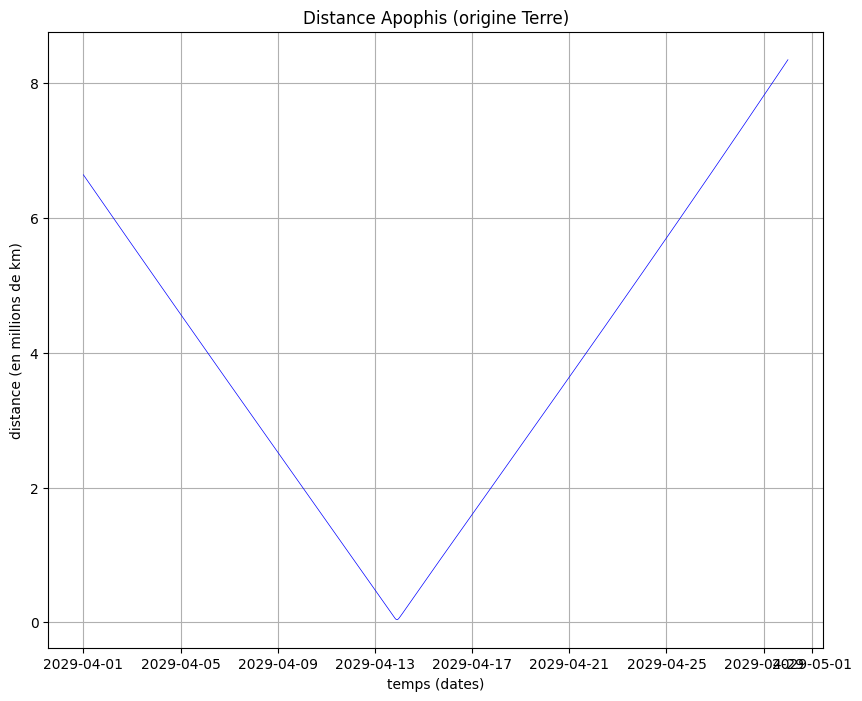

In [ ]:
trace2D(Astre1='Terre', Astre2='Apophis')

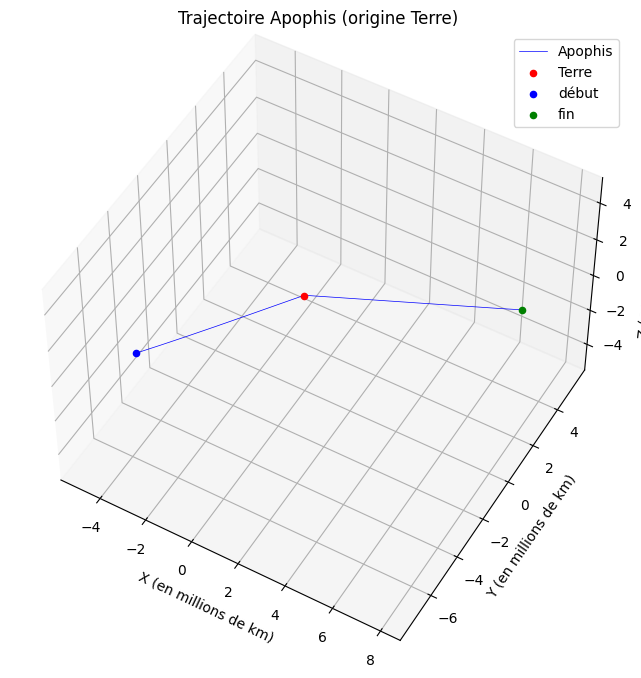

In [ ]:
trace3D(Astre1='Terre', Astre2='Apophis', elev = 50)

In [ ]:
simu_aster_save(Planetes='Planetes.csv',methode='rk8')

Soleil : 132712440041.2794 km^3 s^-2
Mercure : 22031.868551 km^3 s^-2
Venus : 324858.592 km^3 s^-2
Terre : 398600.435507 km^3 s^-2
Lune : 4902.800118 km^3 s^-2
Mars : 42828.375816 km^3 s^-2
Jupiter : 126712764.1 km^3 s^-2
Saturne : 37940584.8418 km^3 s^-2
Uranus : 5794556.4 km^3 s^-2
Neptune : 6836527.10058 km^3 s^-2
Apophis : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:01.628899 (hh:mm:ss.ms)


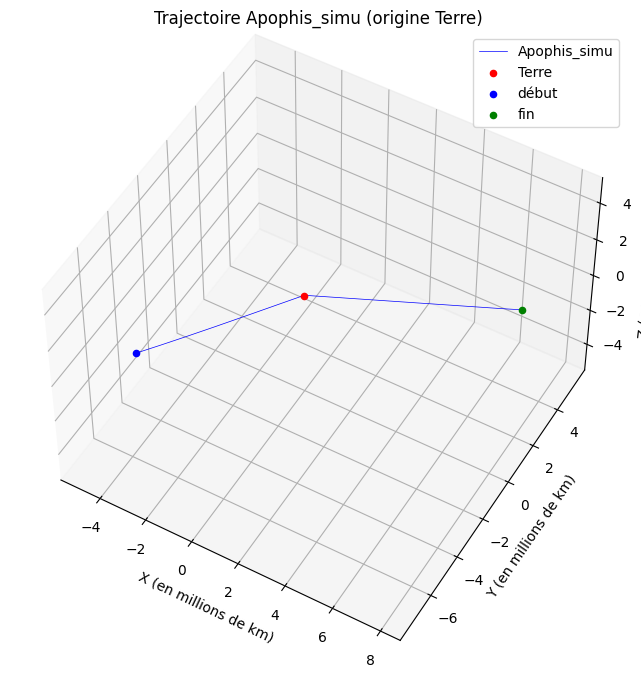

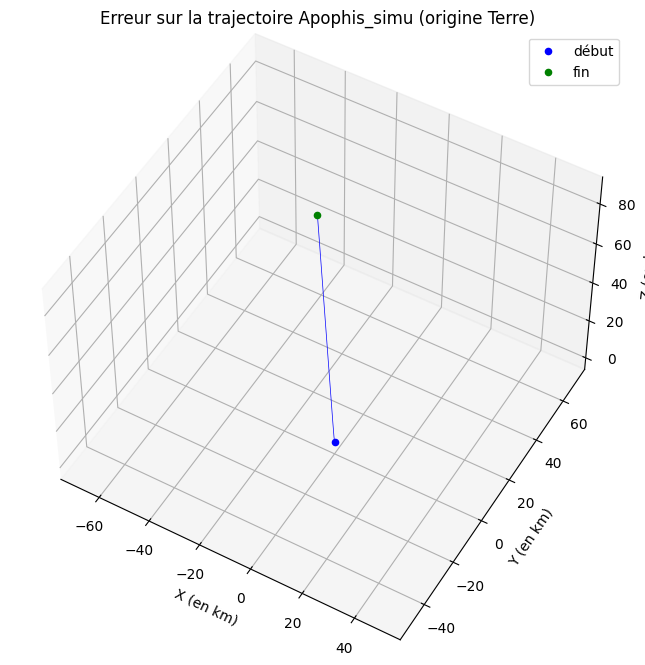

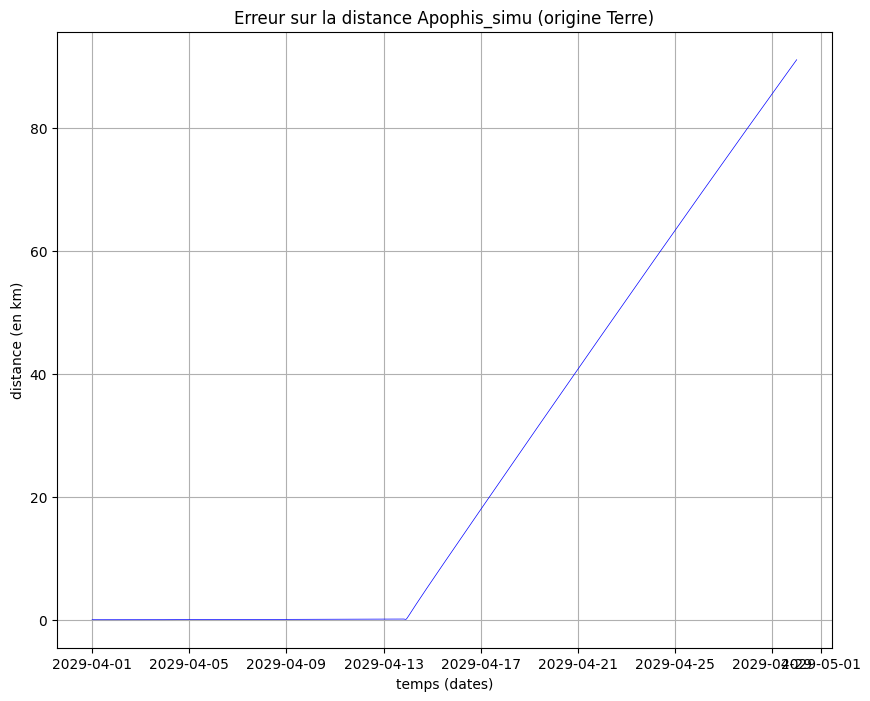

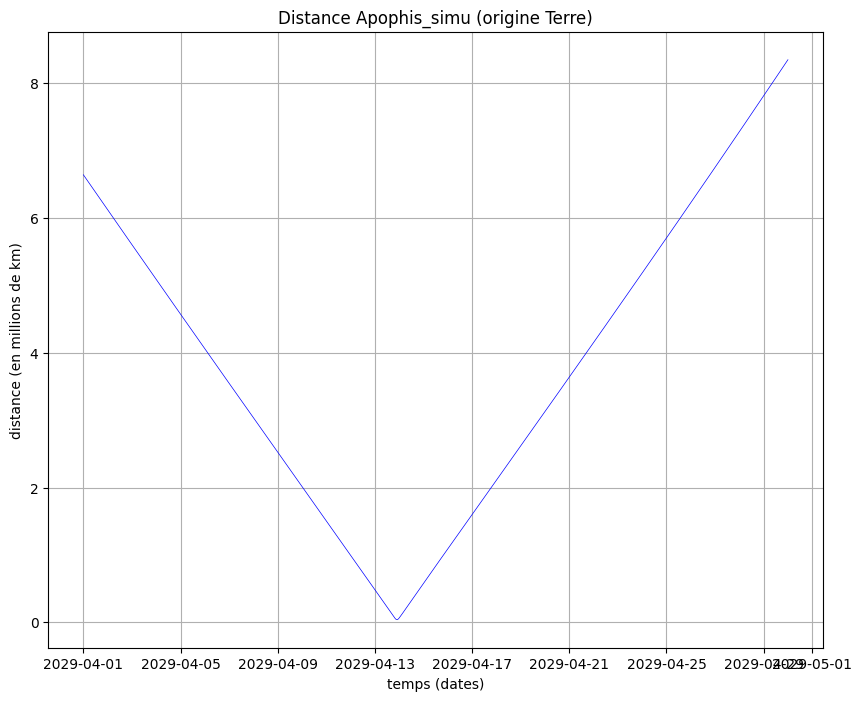

In [ ]:
compare(Astre1_a='Terre',Astre2_a='Apophis',Astre1_b='Terre',Astre2_b='Apophis_simu', elev = 50)

## Cruithne

In [ ]:
planetes(Planetes='Planetes.csv',Ligne = 'Cruithne,0,km^3 s^-2,Cruithne')

         Nom            mu      units        id
0     Soleil  1.327124e+11  km^3 s^-2        10
1    Mercure  2.203187e+04  km^3 s^-2         1
2      Venus  3.248586e+05  km^3 s^-2         2
3      Terre  3.986004e+05  km^3 s^-2       399
4       Lune  4.902800e+03  km^3 s^-2       301
5       Mars  4.282838e+04  km^3 s^-2         4
6    Jupiter  1.267128e+08  km^3 s^-2         5
7    Saturne  3.794058e+07  km^3 s^-2         6
8     Uranus  5.794556e+06  km^3 s^-2         7
9    Neptune  6.836527e+06  km^3 s^-2         8
10  Cruithne  0.000000e+00  km^3 s^-2  Cruithne


In [ ]:
df=lire_info_csv('Planetes.csv')
print(df)

         Nom            mu      units        id
0     Soleil  1.327124e+11  km^3 s^-2        10
1    Mercure  2.203187e+04  km^3 s^-2         1
2      Venus  3.248586e+05  km^3 s^-2         2
3      Terre  3.986004e+05  km^3 s^-2       399
4       Lune  4.902800e+03  km^3 s^-2       301
5       Mars  4.282838e+04  km^3 s^-2         4
6    Jupiter  1.267128e+08  km^3 s^-2         5
7    Saturne  3.794058e+07  km^3 s^-2         6
8     Uranus  5.794556e+06  km^3 s^-2         7
9    Neptune  6.836527e+06  km^3 s^-2         8
10  Cruithne  0.000000e+00  km^3 s^-2  Cruithne


In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2020-01-01 00:00:00',fin='2030-01-01 00:00:00',pas='24 h')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune
Données pour Cruithne


In [ ]:
jpl_affiche('Cruithne')

**********
>>>noms des colonnes :
['JDTDB' 'DATES' 'X' 'Y' 'Z' 'VX' 'VY' 'VZ']

>>>types des colonnes :
JDTDB    float64
DATES     object
X        float64
Y        float64
Z        float64
VX       float64
VY       float64
VZ       float64
dtype: object

>>>aperçu du contenu :
          JDTDB       DATES             X             Y             Z  \
0     2458849.5  2020-01-01 -5.583073e+07 -5.698348e+07  2.842277e+07   
1     2458850.5  2020-01-02 -5.387044e+07 -6.053275e+07  2.860825e+07   
2     2458851.5  2020-01-03 -5.182817e+07 -6.398726e+07  2.874974e+07   
3     2458852.5  2020-01-04 -4.971059e+07 -6.734620e+07  2.884901e+07   
4     2458853.5  2020-01-05 -4.752409e+07 -7.060920e+07  2.890784e+07   
...         ...         ...           ...           ...           ...   
3649  2462498.5  2029-12-28 -3.605534e+07 -8.547206e+07  2.868119e+07   
3650  2462499.5  2029-12-29 -3.358451e+07 -8.820494e+07  2.854387e+07   
3651  2462500.5  2029-12-30 -3.107893e+07 -9.084682e+07  2.837711

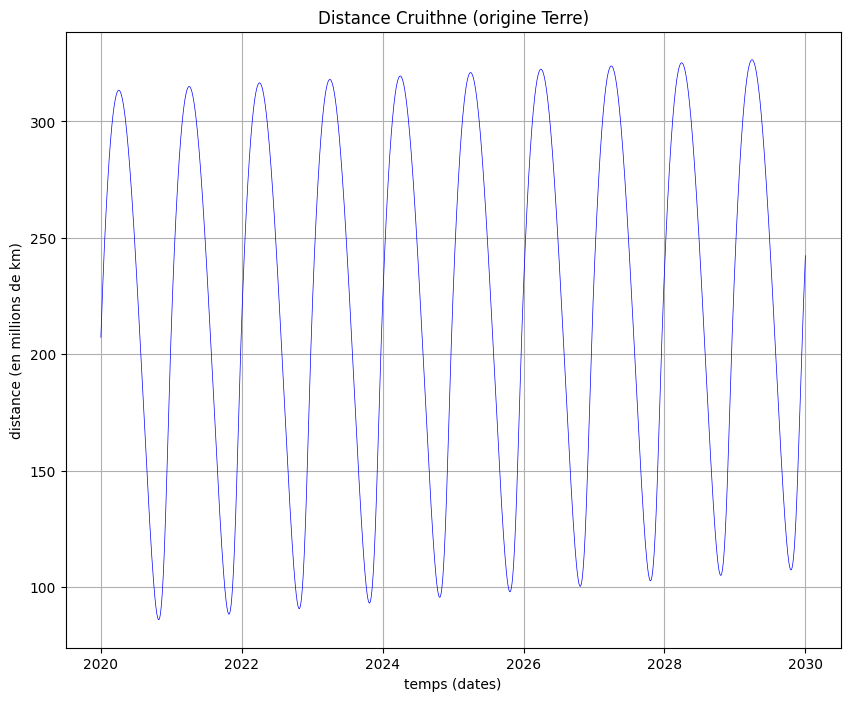

In [ ]:
trace2D(Astre1='Terre', Astre2='Cruithne')

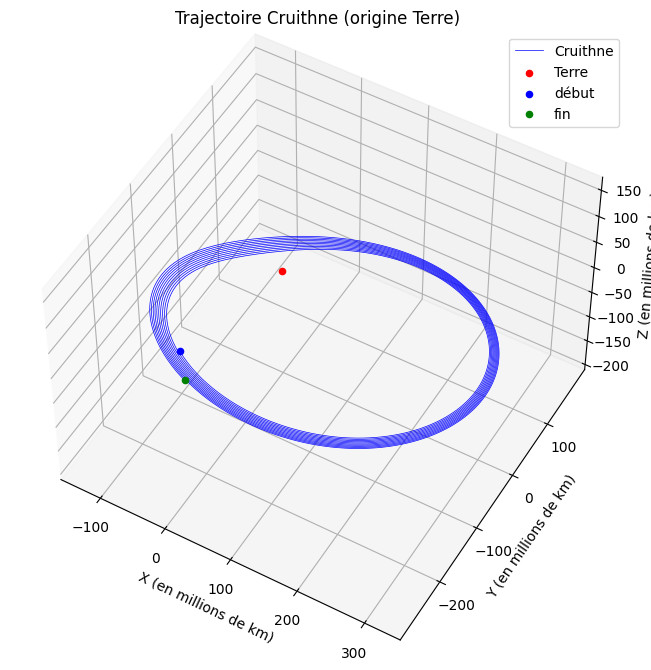

In [ ]:
trace3D(Astre1='Terre', Astre2='Cruithne', elev = 50)

In [ ]:
simu_aster_save(Planetes='Planetes.csv',methode='rk8')

Soleil : 132712440041.2794 km^3 s^-2
Mercure : 22031.868551 km^3 s^-2
Venus : 324858.592 km^3 s^-2
Terre : 398600.435507 km^3 s^-2
Lune : 4902.800118 km^3 s^-2
Mars : 42828.375816 km^3 s^-2
Jupiter : 126712764.1 km^3 s^-2
Saturne : 37940584.8418 km^3 s^-2
Uranus : 5794556.4 km^3 s^-2
Neptune : 6836527.10058 km^3 s^-2
Cruithne : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:08.650955 (hh:mm:ss.ms)


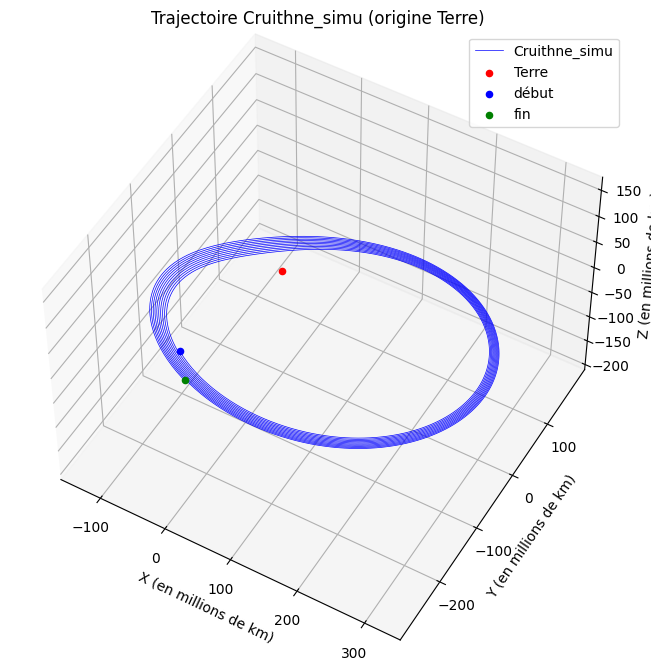

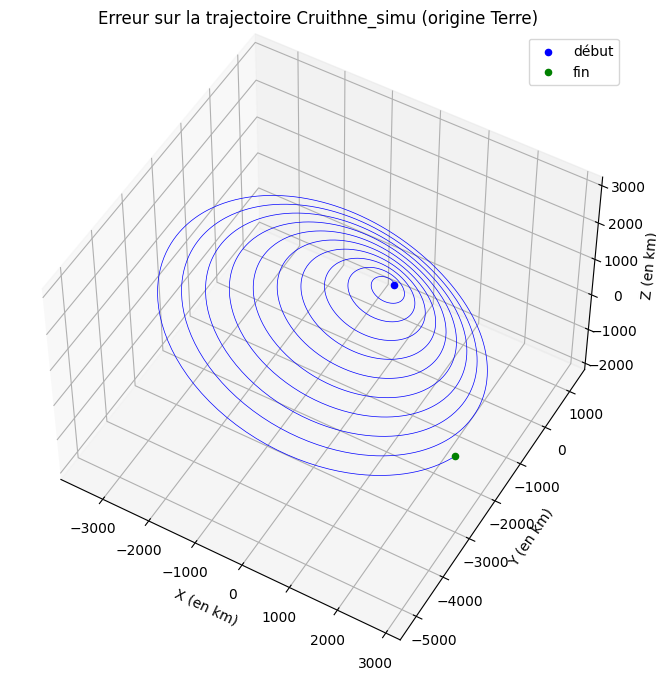

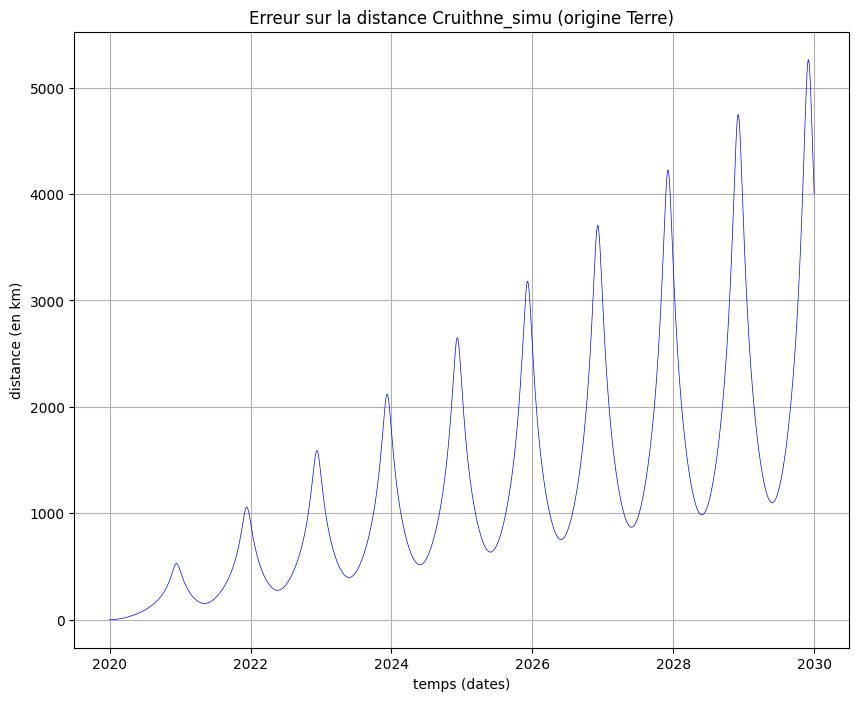

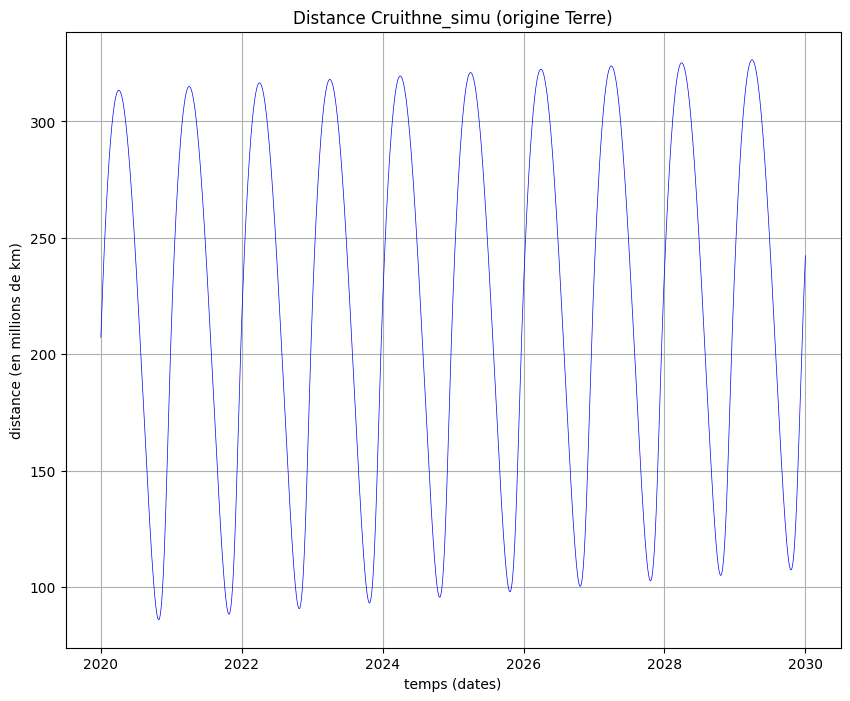

In [ ]:
compare(Astre1_a='Terre',Astre2_a='Cruithne',Astre1_b='Terre',Astre2_b='Cruithne_simu', elev = 50)